In [444]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

In [445]:
N_s = 8
n_s = 3
N_t = 100
lam = 0.6
m = 0.02
dt = 0.05
N_t * dt

5.0

# Truncated

In [446]:
def build_op(N_s, site, op):
    Op = np.identity(1)
    for s in range(N_s):
        if s == site:
            Op = np.kron(op, Op)
        else:
            Op = np.kron(np.identity(2), Op)
    return Op

In [447]:
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
n = np.array([[0, 0], [0, 1]])
sm = np.array([[0, 0], [1, 0]])

X = []
Y = []
Z = []
N = []
Sm = []

for i in range(N_s):
    X.append(build_op(N_s, i, x))
    Y.append(build_op(N_s, i, y))
    Z.append(build_op(N_s, i, z))
    N.append(build_op(N_s, i, n))
    Sm.append(build_op(N_s, i, sm))

H_NN = np.zeros((2**N_s, 2**N_s), dtype=complex)
H_T = np.zeros((2**N_s, 2**N_s), dtype=complex)
H_L = np.zeros((2**N_s, 2**N_s), dtype=complex)

for j in range(N_s):
    H_NN -= lam * X[j] @ X[(j + 1) % N_s]
    H_T -= Z[j]
    H_L -= m * X[j]

TEO = LA.expm(-1j * dt * H_T / 2) @ LA.expm(-1j * dt * H_NN) @ LA.expm(-1j * dt * H_T / 2)
# TEO = TEO @ LA.expm(-1j * dt * H_L)

H = H_NN + H_T
Evals, Evecs = np.linalg.eigh(H)
ground_state = Evecs[:, 0]

# H_int = H_NN + H_T + H_L
# Evals_int, Evecs_int = np.linalg.eigh(H_int)
# ground_state = Evecs_int[:, 0]

CDAG = []
for i in range(N_s):
    cdag = Sm[i]
    for j in range(i):
        cdag = -Z[j] @ cdag
    CDAG.append(cdag)

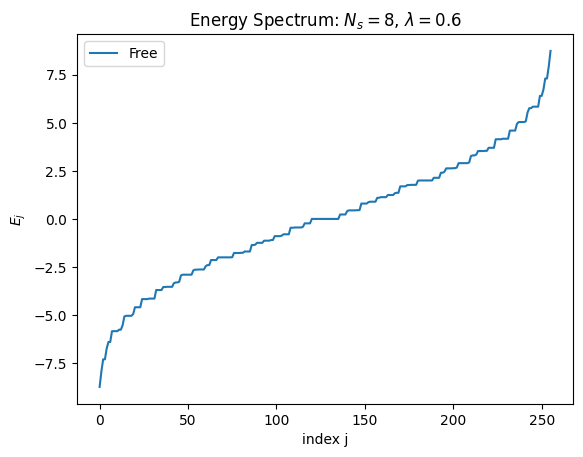

In [448]:
plt.plot(range(2**N_s), Evals, label='Free')
# plt.plot(range(2**N_s), Evals_int, label='Interacting')
plt.xlabel('index j')
plt.ylabel(r'$E_j$')
title = 'Energy Spectrum: '
title += r'$N_s =$' + str(N_s)
title += r', $\lambda=$' + str(lam)
# title += r', $h_L=$' + str(h_L)
plt.title(title)
plt.legend()

In [490]:
xl = 4
r = np.array([-1, 0, 1])
kr_mean = 3 * np.pi / N_s
kl_mean = -kr_mean
sigma = 3/2

rm_op = np.zeros((2**N_s, 2**N_s), dtype=complex)
for i in range(n_s):
    coeff = np.exp(-1j * kr_mean * i)
    coeff *= np.exp(-r[i]**2 / sigma**2)
    op = Sm[i]
    for j in range(i):
        op = -Z[j] @ op
    rm_op += coeff * op

lm_op = np.zeros((2**N_s, 2**N_s), dtype=complex)
for i in range(n_s):
    coeff = np.exp(-1j * kl_mean * (i + xl))
    coeff *= np.exp(-r[i]**2 / sigma**2)
    op = Sm[i + xl]
    for j in range(i + xl):
        op = -Z[j] @ op
    lm_op += coeff * op
# exact_init_state = np.zeros(2**N_s, dtype='complex')
# exact_init_state[0] = 1
exact_init_state = lm_op @ rm_op @ ground_state
exact_init_state /= np.linalg.norm(exact_init_state)

In [491]:
state = np.array(exact_init_state)
exact_occs = []
EEs = []
for t in range(N_t):
    occ = []
    for j in range(N_s):
        occ_j = np.inner(state.conjugate(), N[j] @ state)
        occ.append(occ_j)
    exact_occs.append(np.real(occ))

    C = state.reshape((16, 16))
    rho_A = C @ C.conj().transpose()
    Evals = np.linalg.eigvals(rho_A)
    Evals = Evals[np.abs(Evals) > 0]
    EE = -np.sum(Evals * np.log(Evals))
    EEs.append(EE)

    state = TEO @ state

Text(0.5, 1.0, 'Ground State Occupation Number: N=8')

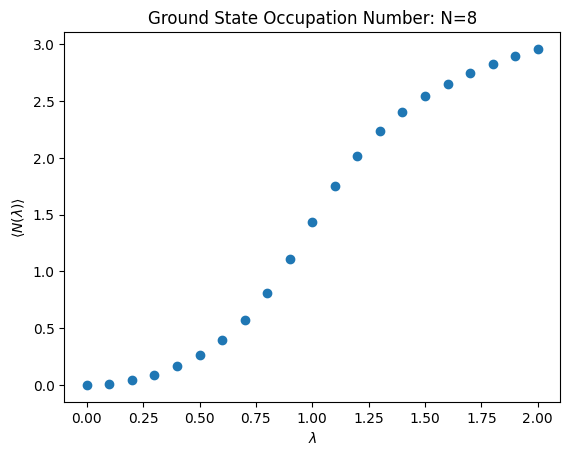

In [478]:
ground_occ = [0, 0.010018835847120664,
              0.040306948435523404, 0.09162439971786754,
              0.16558839061886294, 0.26558270901360836,
              0.39842476279538724, 0.5758649666658388,
              0.8117687755094547, 1.108119204422794,
              1.4370845522584879, 1.7512830697165573,
              2.018493298831889, 2.233216639716095,
              2.4038893715552003, 2.5412125472817646,
              2.653925920186832, 2.748338585634355,
              2.8288626023355388, 2.8985955751208765,
              2.9597523468325098]

plt.scatter(np.arange(0, 2.1, 0.1), ground_occ)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\langle N(\lambda) \rangle$')
plt.title('Ground State Occupation Number: N=8')

# With Givens Rotations

In [513]:
from givens_angles import *

In [514]:
betas_r, angles_r = giv_angles(N_s, 3, 1, 3, sigma)
betas_l, angles_l = giv_angles(N_s, 3, 5, -3, sigma)

In [515]:
def RZ(theta, q):
    op = LA.expm(-1j * theta / 2 * Z[q])
    return op

def Giv_Op(theta, j, k):
    op = X[j] @ Y[k] - Y[j] @ X[k]
    op = LA.expm(1j * theta / 2 * op)
    return op

In [516]:
giv_init_state = ground_state.copy()
# giv_init_state = np.zeros((2**N_s), dtype=complex)
# giv_init_state[0] = 1

# Right moving wave packet
for i in range(3):
    giv_init_state = RZ(betas_r[i], i) @ giv_init_state
for i in range(2):
    j = 1 - i
    giv_init_state = Giv_Op(angles_r[i], j, j+1) @ giv_init_state

giv_init_state = Sm[0] @ giv_init_state

for i in range(2):
    j = 1 - i
    giv_init_state = Giv_Op(angles_r[j], i, i+1).conj().transpose() @ giv_init_state
for i in range(3):
    giv_init_state = RZ(-betas_r[i], i) @ giv_init_state

# Left moving wave packet
for i in range(3):
    giv_init_state = RZ(betas_l[i], i+4) @ giv_init_state
for i in range(2):
    j = 5 - i
    giv_init_state = Giv_Op(angles_l[i], j, j+1) @ giv_init_state

giv_init_state = CDAG[4] @ giv_init_state

for i in range(2):
    j = 1 - i
    giv_init_state = Giv_Op(angles_l[j], i+4, i+5).conj().transpose() @ giv_init_state
for i in range(3):
    giv_init_state = RZ(-betas_l[i], i+4) @ giv_init_state

giv_init_state /= np.linalg.norm(giv_init_state)

In [517]:
giv_state = giv_init_state.copy()
giv_occs = []
giv_EEs = []
for _ in range(N_t):
    occs = []
    for j in range(N_s):
        occ = np.inner(giv_state.conjugate(), N[j] @ giv_state)
        occs.append(np.real(occ))
    giv_occs.append(occs)

    C = giv_state.reshape((16, 16))
    rho_A = C @ C.conj().transpose()
    Evals = np.linalg.eigvals(rho_A)
    Evals = Evals[np.abs(Evals) > 0]
    EE = -np.sum(Evals * np.log(Evals))
    giv_EEs.append(EE)

    giv_state = TEO @ giv_state

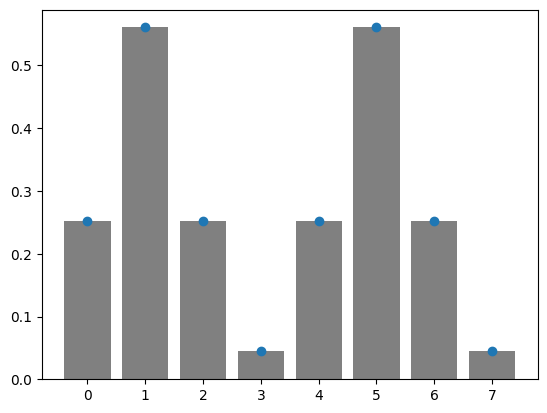

In [518]:
plt.bar(range(N_s), exact_occs[0], color='grey')
plt.scatter(range(N_s), giv_occs[0])

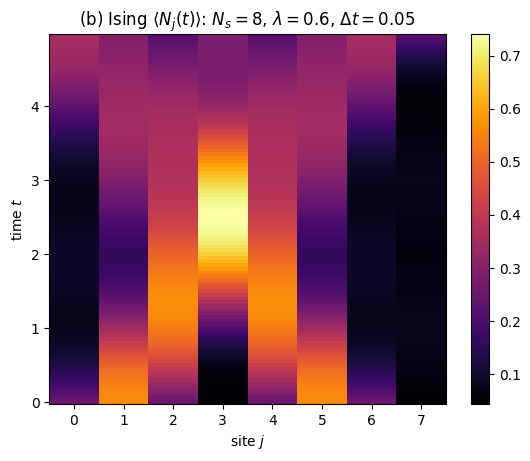

In [519]:
plt.pcolormesh(Sites, Times, exact_occs, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(b) Ising $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()

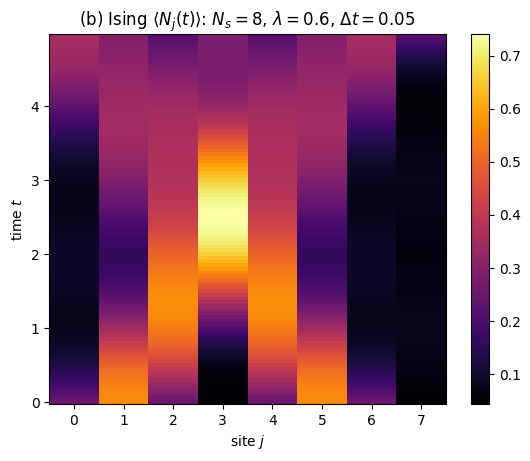

In [520]:
plt.pcolormesh(Sites, Times, giv_occs, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(b) Ising $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()

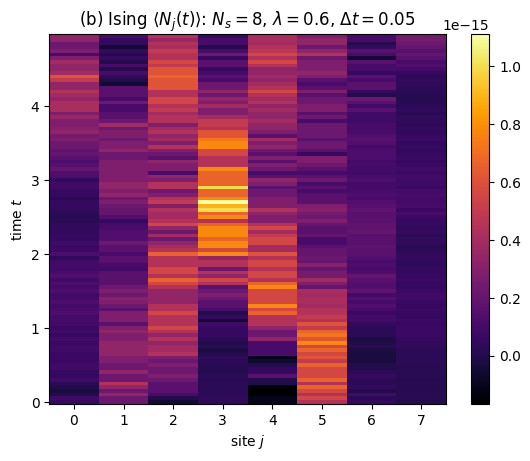

In [529]:
diff = np.array(exact_occs) - np.array(giv_occs)
plt.pcolormesh(Sites, Times, diff, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(b) Ising $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
title += r', $\Delta t=$' + str(dt)
plt.title(title)
plt.colorbar()

Text(0.5, 1.0, '(c) Entanglement Entropy: $N_s = $8, $\\lambda = $0.6, $\\Delta t=$0.05')

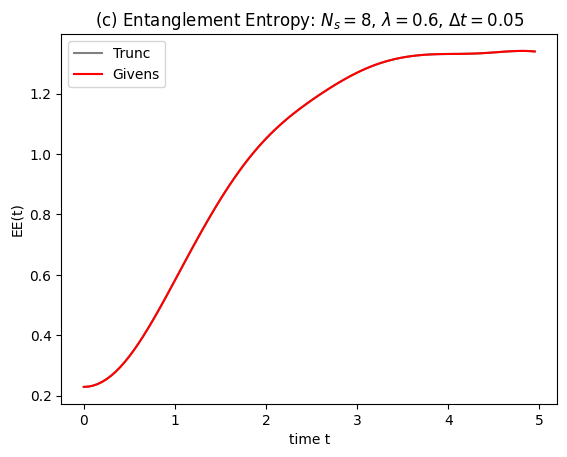

In [ ]:
plt.plot(times, EEs, label='Trunc', color='grey')
plt.plot(times, giv_EEs, label='Givens', color='red')
plt.xlabel('time t')
plt.ylabel('EE(t)')
plt.legend()
title = r'(c) Entanglement Entropy: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
title += r', $\Delta t=$' + str(dt)
plt.title(title)

In [523]:
nks = np.arange(-N_s + 1, N_s + 1, 2)
ETADAG = []
for i in range(N_s):
    k = nks[i] * np.pi / N_s
    etadag = np.zeros((2**N_s, 2**N_s), dtype=complex)
    for j in range(N_s):
        etadag += 1 / np.sqrt(N_s) * np.exp(-1j * k * j) * CDAG[j]
    ETADAG.append(etadag)

In [524]:
four_spec = []
giv_four_spec = []
for i in range(N_s - 1):
    for j in range(i+1, N_s):
        k_state = ETADAG[i] @ ETADAG[j] @ ground_state

        amp = np.inner(k_state.conj(), exact_init_state)
        four_spec.append(amp * amp.conj())

        amp = np.inner(k_state.conj(), giv_init_state)
        giv_four_spec.append(amp * amp.conj())

Text(0.5, 1.0, 'Fourier Spectrum: $N_s=$8$,\\;n_s=$3$,\\; n_k = \\pm3$$,\\;\\sigma=$1.5,$\\;\\lambda=$0.6')

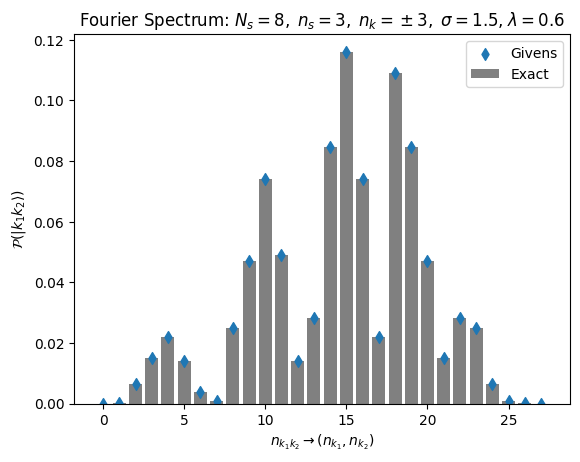

In [525]:
plt.bar(range(len(four_spec)), four_spec, label='Exact', color='grey')
plt.scatter(range(len(giv_four_spec)), giv_four_spec, label='Givens', marker='d')
plt.xlabel(r'$n_{k_1k_2} \rightarrow (n_{k_1}, n_{k_2})$')
plt.ylabel(r'$\mathcal{P}(|k_1k_2\rangle)$')
plt.legend()
title = 'Fourier Spectrum: '
title += r'$N_s=$' + str(N_s)
title += r'$,\;n_s=$' + str(n_s)
title += r'$,\; n_k = \pm3$'
title += r'$,\;\sigma=$' + str(sigma)
title += r',$\;\lambda=$' + str(lam)
plt.title(title)

In [526]:
np.sum(giv_four_spec)

(0.9135861039517107+0j)

In [527]:
np.sum(four_spec)

(0.913586103951711+0j)

In [528]:
np.inner(giv_init_state.conj(), exact_init_state)

(1.0000000000000004-1.732555071631836e-16j)